In [37]:
import csv
import pickle
import cv2
from pandas import DataFrame
import numpy as np
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely import geometry
from keras.models import model_from_json
from keras import models
def AreaOfContour(x):
    return x[2]*x[3]

def FilterContours(cordinates):
    # Creating the Numpy array of filtered Contour Coordinates
    ContourInfo = np.array(cordinates)
    # Finding the Area of each contour and concatenating the area to axis of numpy array
    ContourAreas = np.apply_along_axis(AreaOfContour,1,ContourInfo)[:,None]
    ContourInfo = np.concatenate([ContourInfo,ContourAreas],axis=1)
    # Sorting the Contours based on the Area of contours
    ContourInfo = ContourInfo[ContourInfo[:,4].argsort()[::-1]]
    # Adding Flag of Table boundary to Contoursa
    ContourInfo = np.concatenate([ContourInfo,np.zeros(len(ContourInfo)).astype(int)[:,None]],axis=1)


    count = 0

    # Filtering the Inner Bounded Contours from Tables by looping the through the Contours sorted by Area,
    # All contours will be checked with the First level area contours if it fits inside, which ever iside of it, will be Deleted from that.
    while (len(ContourInfo) !=  ContourInfo[:,5].sum()):
        # Picking First level of Contour from Area
        ContourInfo[count][-1] = 1
        Cont1 = ContourInfo[count]
        x,y,w,h = Cont1[0],Cont1[1],Cont1[2],Cont1[3]
        polygon = geometry.polygon.Polygon([(x,y),(x,y+h),(x+w,y+h),(x+w,y)])

        InnerContours = []
        # Checking the Each contour one by one till it reaches to Low level and appending the rows of contours inside of it
        for val,Cont2 in enumerate(ContourInfo[count+1:]):
            #Cont2 = ContourInfo[1]
            X,Y,W,H = Cont2[0],Cont2[1],Cont2[2],Cont2[3]
            if any([polygon.contains(Point(point)) for point in [(X,Y),(X,Y+H),(X+W,Y+H),(X+W,Y)]]):
                other_polygon = geometry.polygon.Polygon([(X,Y),(X,Y+H),(X+W,Y+H),(X+W,Y)])
                if polygon.intersection(other_polygon).area/other_polygon.area > 0.45:
                    InnerContours.append(val+count+1)
        # Deleting the Contours which are inside of it.
        ContourInfo = np.delete(ContourInfo,InnerContours, axis=0)
        count +=1
    return ContourInfo    


def PreprocessEmbeddings(n):
  m = n.copy()
  m  = (m.max()-m)*(255/m.max())
  m = np.dstack([m,m,m])
  return m
def ApplyContours(image, kernel_size=3, thickness=1, iterations = 11):
  #im = np.dstack([image,image,image])
  im = PreprocessEmbeddings(image)
  im1 = image.copy()

  # kernel = np.ones((kernel_size, kernel_size),np.uint8)
  # dilated = cv2.dilate(thresh1,kernel,iterations = iterations)
  # We use cvtColor, to convert to grayscale 
  gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 

  ret,thresh1 = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY_INV)
  contours, hierarchy = cv2.findContours(thresh1.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    

  cordinates = []
  contours1 = []
  # Extracting the Outer Bound boxes
  #contours = [(cnt,hie)[0] for cnt,hie in zip(contours,hierarchy[0]) if hie[2] != -1]
  # Extracting the Boxes with more than 8% area
  for cnt,hie in zip(contours,hierarchy[0]):
      #x,y,w,h = cnt[0],cnt[1],cnt[2],cnt[3]
      x,y,w,h = cv2.boundingRect(cnt)
      #bound the images
      if hie[-1]==-1:
          #bound the images
          cordinates.append((x,y,w,h, cv2.contourArea(cnt)))
          cv2.rectangle(im1,(x,y),(x+w,y+h),(0,255,0),thickness)
          #im = cv2.putText(im, str(count), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
          contours1.append(cnt)
  df = DataFrame(cordinates, columns = ['x','y','w','h','area'])    
  df[['x', 'w']] = df[['x', 'w']].multiply(480/im1.shape[0]).astype(int)
  df[['y', 'h']] = df[['y', 'h']].multiply(640/im1.shape[1]).astype(int)
  return df, im1



def AdjustContours(df, im1):
  df['thr'] = pd.cut(df['y'], bins=np.arange(0,480,50), labels=np.flip(np.multiply(np.arange(9),5))).fillna(0).astype(int)
  df['x'] = df['x'] - df['thr']
  df['y'] = df['y'] - df['thr'].multiply(2)
  df.loc[df['x'].lt(0), 'x'] = 0
  df.loc[df['y'].lt(0), 'y'] = 0
  df['h'] = df['h'] + df['thr']
  df['w'] = df['w'] + df['thr'].multiply(1.5)


  FilteredConts = FilterContours(df.values[:,:4])
  Original = im1.copy()
  df1 = pd.DataFrame(FilteredConts[:,:4].astype(int), columns=['x','y','w','h'])
  df[['x','y','w', 'h']] = df[['x','y','w', 'h']].astype(int)
  df1[['x','y','w', 'h']] = df1[['x','y','w', 'h']].astype(int)
  df = df.merge(df1, on=['x','y','w','h'], how='inner')

  ImSegments = []
  for ind, row in df.iterrows():
      x,y,w,h = row[['x','y','w','h']].astype(int).values
      cv2.rectangle(im1,(x,y),(x+w,y+h),(0,255,0),2)
      ImSegments.append(Original[y:y+h,x:x+w])
      
  return df, im1, ImSegments


def FilterImage(word):
  shape = np.array(word.shape[:2])
  w,l = np.divide(np.subtract(shape.max(),shape),2).astype(int)
  word = cv2.copyMakeBorder(word, w, w, l, l,cv2.BORDER_CONSTANT,value=[255,255,255])    
  if shape.max()<480:
    word = cv2.resize(word, (480,480))
  w, l = np.divide(np.subtract(np.array([480, 640]),max(word.shape)),2).astype(int)
  word = cv2.copyMakeBorder(word, w, w, l, l,cv2.BORDER_CONSTANT,value=[255,255,255])
  word = cv2.resize(word, (640, 480))
  return word


def Preoprocessimage(a, ModeofImage):
  #a[np.abs(a[:,:,0]-m[:,:,0])<10] = 255
  a[np.abs(a.sum(2) - ModeofImage.sum(2))<25] = 255
  kernel = np.ones((2,2),np.uint8)
  b = cv2.morphologyEx(a, cv2.MORPH_OPEN, kernel)
  b = cv2.GaussianBlur(b,(3,3),0)
  return b

def GetNoofPersons(points, row):
  coords = points[((points[:,0]>row['x']) & (points[:,0]<(row['x']+row['w']))) & ((points[:,1]>row['y']) & (points[:,1]<(row['y']+row['h'])))]
  return coords.shape[0]

def GenerateInsideData(activation_model, array, image, points=None, testing=False):
  # Buidling inbetween 6 layer model of trained model
  a = activation_model.predict(array)
  # print(int(model.predict(array)[0][0]), '  -  ', labels[rvalue])

  # Taking Fifthe layer Embeddings to represent the Convolution features of Images
  first_layer_activation = a[5]
  n = first_layer_activation[0, :, :, 0].copy()
  # Applying the Median Blur Image processing technique to reduce Noise of images
  n = cv2.medianBlur(n,3)
  # Applying the Median Blur Image processing technique to reduce Noise of images
  n[n<n.max()/3] = 0
  n = cv2.medianBlur(n,3)

  # Applyint Contours to detected crowd patterns
  df, im1 = ApplyContours(n.copy())

  # Adjusting the multiple contours and the area wise dilation of contours from Camera angle
  df, im2, ImSegments = AdjustContours(df, image.copy())

  # Filter and zero padding the images to apply on the Crowd Counting model
  CrowdGroups  = np.concatenate([FilterImage(word)[np.newaxis] for word in ImSegments])
  if testing:
    return df, CrowdGroups,n,im2

  # Assigning Number of persons associated with the each Cluster cropped
  df['NoofPersons'] = df.apply(lambda x: GetNoofPersons(points, x), 1)

  #df['Images'] = CrowdGroups
  return df, CrowdGroups

def LoadModels():
    # load json and create model
    json_file = open('model1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    GroupModel = model_from_json(loaded_model_json)
    # load weights into new model
    GroupModel.load_weights("model1.h5")
    print("Loaded model from disk")
     
            
    # load json and create model
    json_file = open('PersonModel.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    PersonModel = model_from_json(loaded_model_json)
    # load weights into new model
    PersonModel.load_weights("PersonModel.h5")
    print("Loaded model from disk")
    
    # Extracts the outputs of the top 12 layers
    layer_outputs = [layer.output for layer in  GroupModel.layers[:12]] 
    # Creates a model that will return these outputs, given the model input
    activation_model = models.Model(inputs=GroupModel.input, outputs=layer_outputs) 
    
    return GroupModel, PersonModel, activation_model


def PlotGroups(im1, df1, font=0.7):
  for ind, row in df1.iterrows():
      x,y,w,h = row[['x','y','w','h']].astype(int).values
      cv2.rectangle(im1,(x,y),(x+w,y+h),(0,255,0),2)
      cv2.putText(im1, 'group size - '+ str(int(row['NoofPersons'])), 
                  (x,y+20),  cv2.FONT_HERSHEY_SIMPLEX , font, (255, 0, 0), 2, cv2.LINE_AA) 
  return im1



In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive1 = GoogleDrive(gauth)


In [8]:
IMAGE_FILE_ID = "1jQDIE44OlMA3_XcisfxR0DNAbO4GwnuD"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('model1.json')   

IMAGE_FILE_ID = "1-4b8xd4yILyzxRje3zqfXfWvx1QDKqfD"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('model1.h5')        

IMAGE_FILE_ID = "1a30DGSP-0mHlTe4p2BS8n7VM2BJCA6Kn"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('PersonModel.h5')        

IMAGE_FILE_ID = "1guVA9jjDBFHIa4_R_0700ibYfwfM4SPb"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('PersonModel.json')   

IMAGE_FILE_ID = "1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('images.npy')  

IMAGE_FILE_ID = "1-1mTC7LoC9rLCUE-RxSitOOSBARC2e9v"
downloaded = drive1.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('ModeOfImage.npy') 

In [12]:
GroupModel, PersonModel, activation_model = LoadModels()

Loaded model from disk
Loaded model from disk


In [14]:
img = np.load('images.npy')
ModeofImage = np.load('ModeOfImage.npy')

In [42]:
rvalue = np.random.randint(2000)
image = img[rvalue]


array = Preoprocessimage(image.copy(), ModeofImage)[None,:]

df, CG, n, im2 = GenerateInsideData(activation_model, array, image.copy(), testing=True)

df['NoofPersons'] = PersonModel.predict(CG).flatten()
df1 = df.loc[df['NoofPersons']>3]
im1 = image.copy()
im1 = PlotGroups(im1, df1, font=0.8)

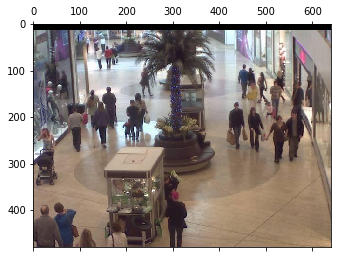

In [43]:
plt.matshow(image, cmap='viridis')

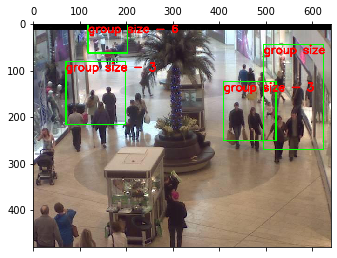

In [44]:
plt.matshow(im1, cmap='viridis')